In [7]:
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict , Annotated
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
memory = MemorySaver()

In [10]:
@tool
def get_stock_price(symbol: str)-> float:
    '''When stock prize realted comes use this method to return the value with respect to the symbol. Return the current price of a stock market for the  given stock symbol 
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT" : 200.3,
        "AAPL" : 100.4,
        "AMZN" : 150.0,
        "RIL" :87.6
    }.get(symbol,0.0)

### list of tools

tools = [get_stock_price]

llm = init_chat_model("llama-3.3-70b-versatile",model_provider="groq")
llm_with_tools = llm.bind_tools(tools)

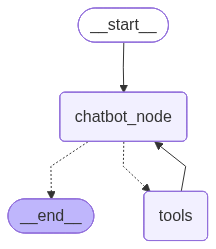

In [11]:
class State(TypedDict):
    messages : Annotated[list,add_messages] 


def chatbot(state: State) -> State:
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(State)

builder.add_node("chatbot_node",chatbot)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START,"chatbot_node")
builder.add_conditional_edges("chatbot_node",tools_condition )
builder.add_edge("tools","chatbot_node")
builder.add_edge("chatbot_node",END)

graph = builder.compile(checkpointer=memory)

from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langsmith import traceable

config = {"configurable":{'thread_id':"2"}}

@traceable
def call_graph(query: str):
    message= {"role": "user","content":query}
    response = graph.invoke({"messages":[message]},config)
    return response["messages"][-1].content

print(call_graph(query="I want to buy 20 AMZN stocks using current price. Then 15 MSFT stock. what will be the total cost?"))

To calculate the total cost, we need to multiply the number of stocks by the current price for each stock and then add the costs together.

For AMZN: 20 * 150.0 = 3000
For MSFT: 15 * 200.3 = 3004.5

The total cost is: 3000 + 3004.5 = 6004.5
